In [155]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules, fpgrowth

## Exploratory Data Analysis

The GroceryDataSet is a list of transcations make at a grocery store. The dataset comes from the University of California, Irvine, their machine learning dataset.

In [149]:
df = pd.read_csv('GroceryDataSet.csv', header=None).fillna(0)

In [150]:
df.shape

(9835, 32)

In [151]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,citrus fruit,semi-finished bread,margarine,ready soups,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,tropical fruit,yogurt,coffee,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,whole milk,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,pip fruit,yogurt,cream cheese,meat spreads,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,other vegetables,whole milk,condensed milk,long life bakery product,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [174]:
df.ne(0).sum().sum() / (df.shape[0] * df.shape[1])

0.13779550076258262

When loading the data there was a lot of nan values which were filled with 0 to indicate there are no transcations past the last. The dataset contain 9835 market transcations which are mostly empty with only 13% of it's cells filled.

### Data Preparation

To get a better understanding of the dataset, the data will be transformed so each row is a transcation and each column is an item where the values are True or False if the item was purchased or not

![](data_prep.png)

In [131]:
all_items = df.apply(lambda x: [i for i in x if i != 0], axis=1).values.tolist()

mlxtend TransactionEncoder class is used to transform the data

In [166]:
trans_encoder = TransactionEncoder()
trans_encoder_matrix = trans_encoder.fit(all_items).transform(all_items)
tdf = pd.DataFrame(trans_encoder_matrix, columns=trans_encoder.columns_).astype(int)

In [261]:
tdf.head()

,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,baby food,bags,baking powder,bathroom cleaner,beef,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


The transformation looks correct but we will verify the first row with the original dataset

In [178]:
tdf[['citrus fruit', 'semi-finished bread' ,'margarine', 'ready soups']].head()

,citrus fruit,semi-finished bread,margarine,ready soups
0,1,1,1,1
1,0,0,0,0
2,0,0,0,0
3,0,0,0,0
4,0,0,0,0


Those values are correct

With the data fully transformed we can explore some top 10 most purchased items.

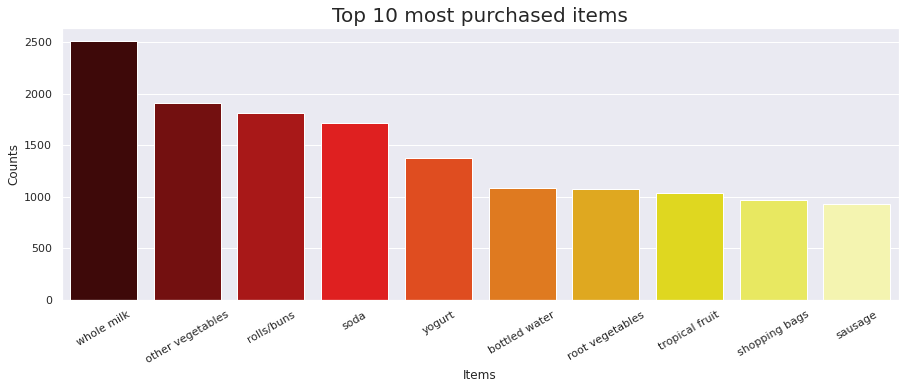

In [182]:
plt.figure(figsize=(15,5))
sns.barplot(x=tdf.sum().nlargest(10).index , y=tdf.sum().nlargest(10).values, palette = 'hot')
plt.xlabel('Items', size = 12)
plt.xticks(rotation=30)
plt.ylabel('Counts', size = 12)
plt.title('Top 10 most purchased items', size = 20)
plt.show()

This looks almost like my grocery transactions, milk and vegetables are definitely on top

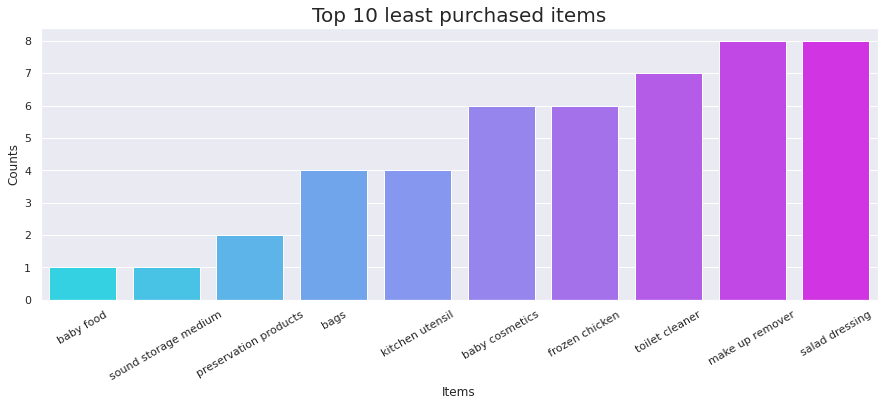

In [183]:
plt.figure(figsize=(15,5))
sns.barplot(x=tdf.sum().nsmallest(10).index , y=tdf.sum().nsmallest(10).values, palette = 'cool')
plt.xlabel('Items', size = 12)
plt.xticks(rotation=30)
plt.ylabel('Counts', size = 12)
plt.title('Top 10 least purchased items', size = 20)
plt.show()

This grocery store makes most of it's revenue from whole milk and vegetables and the least from baby food and sound storage medium.

In [191]:
tdf.sum(1).describe().iloc[1:]

mean     4.409456
std      3.589385
min      1.000000
25%      2.000000
50%      3.000000
75%      6.000000
max     32.000000
dtype: float64

We can see on average a customer puchases 4.4 items where the longest chain is 32 items long, that was a very active shopper. As expected the minimum puchase is 1 since there are no rows with all 0s

### Model building

Apriori is a popular algorithm for extracting frequent itemsets with applications in association rule learning. The apriori algorithm has been designed to operate on databases containing transactions, such as the one we are using.

In [223]:
frequent_itemsets = apriori(tdf, min_support=0.001, use_colnames=True, max_len=2).assign(
        length=lambda x: x['itemsets'].map(lambda x: len(x))
)

In [224]:
frequent_itemsets.head()

,support,itemsets,length
0,0.008033,(Instant food products),1
1,0.033452,(UHT-milk),1
2,0.003559,(abrasive cleaner),1
3,0.003254,(artif. sweetener),1
4,0.017692,(baking powder),1


With the frequent itemsets we can get the association between items using association_rules

In [214]:
rules = association_rules(rule_items, metric="lift", min_threshold=1).sort_values('lift', ascending=False)

In [243]:
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
4144,(mustard),(mayonnaise),0.011998,0.009151,0.001423,0.118644,12.965160,0.001314,1.124233
4145,(mayonnaise),(mustard),0.009151,0.011998,0.001423,0.155556,12.965160,0.001314,1.170002
13,(hamburger meat),(Instant food products),0.033249,0.008033,0.003050,0.091743,11.421438,0.002783,1.092166
12,(Instant food products),(hamburger meat),0.008033,0.033249,0.003050,0.379747,11.421438,0.002783,1.558640
2657,(detergent),(softener),0.019217,0.005491,0.001118,0.058201,10.600137,0.001013,1.055968


The association_rules returns 9 columns, but we are only interested in the first two and support, confidence and lift. Antecendents and Consequents are pairs of items that have associations and their strength is given by the lift/confidence. 

- Support is the joint probability of the antecendents and consequents [0,1]
- Confidence is the conditional probability P(consequents|antecedents) [0,1]
- Lift is a combination of Support and Confidence, range  [0, inf]

#### Model exploration

Now that we have the rules we can take a look at different associations

In [244]:
rules[rules['lift'].gt(1) & rules['confidence'].gt(0.6)]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
3781,(honey),(whole milk),0.001525,0.255516,0.001118,0.733333,2.870009,0.000729,2.791815
1597,(cereals),(whole milk),0.005694,0.255516,0.003660,0.642857,2.515917,0.002206,2.084555
4963,(rice),(whole milk),0.007626,0.255516,0.004677,0.613333,2.400371,0.002729,1.925390


Selecting rows with high lift and confidence score we can see a strong association between (honey, cereals and rice) with whole milk.

In [238]:
rules['support'].describe()

count    5428.000000
mean        0.004008
std         0.005128
min         0.001017
25%         0.001423
50%         0.002339
75%         0.004372
max         0.074835
Name: support, dtype: float64

We see that the support for all rules in our dataset is very low (i.e., the proportion of transactions that involve items from both baskets), which may be problematic, due to the fact that any results obtained from analysis may not be statistically significant.

In [239]:
rules.loc[rules['lift'].idxmax()]

antecedents              (mustard)
consequents           (mayonnaise)
antecedent support        0.011998
consequent support        0.009151
support                   0.001423
confidence                0.118644
lift                      12.96516
leverage                  0.001314
conviction                1.124233
Name: 4144, dtype: object

We see that itemsets mustard and mayonnaise have the highest lift. So if we know that a customer has bought mustard they are ~13 times more likely that they will purchase mayonaise as well. But as we've pointed out, due to the fact that the support is very low, we cannot really determine whether this is just a fluke or a real association.

In [240]:
rules.loc[rules['lift'].idxmin()]

antecedents                    (rolls/buns)
consequents           (specialty chocolate)
antecedent support                 0.183935
consequent support                 0.030402
support                            0.005592
confidence                         0.030404
lift                               1.000063
leverage                                0.0
conviction                         1.000002
Name: 5011, dtype: object

We see that itemsets rolls/buns and specialty chocolate have the lowest lift. The low lift makes sense because I can't think of a reason to have those two items together

In [254]:
rules[rules['consequents'].map(lambda x: list(x)[0]).eq('whole milk')].query('lift > 2')

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
3781,(honey),(whole milk),0.001525,0.255516,0.001118,0.733333,2.870009,0.000729,2.791815
1597,(cereals),(whole milk),0.005694,0.255516,0.003660,0.642857,2.515917,0.002206,2.084555
4963,(rice),(whole milk),0.007626,0.255516,0.004677,0.613333,2.400371,0.002729,1.925390
2111,(cocoa drinks),(whole milk),0.002237,0.255516,0.001322,0.590909,2.312611,0.000750,1.819850
4931,(pudding powder),(whole milk),0.002339,0.255516,0.001322,0.565217,2.212062,0.000724,1.712313
3941,(jam),(whole milk),0.005389,0.255516,0.002949,0.547170,2.141431,0.001572,1.644069
223,(baking powder),(whole milk),0.017692,0.255516,0.009253,0.522989,2.046793,0.004732,1.560725
2265,(cooking chocolate),(whole milk),0.002542,0.255516,0.001322,0.520000,2.035097,0.000672,1.551008


Earler we saw that whole milk was the most frequently bought item, now we look at it's association. Items like cereals and honey are at the top probabily because we eat cereal with milk and put honey in our tea. A lot of the items involve baking as well, like baking powder, pudding powder, cooking chocolate and cocoa drinks.

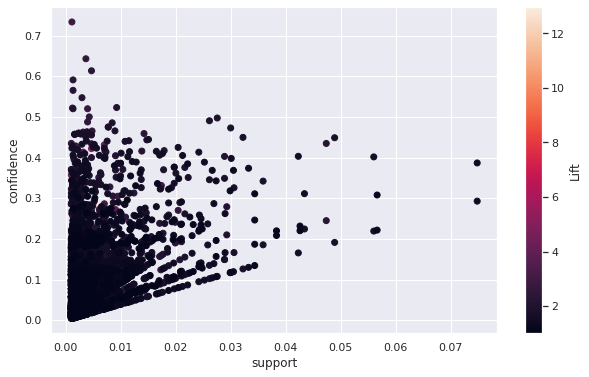

In [256]:
sup = rules['support'].values
conf = rules['confidence'].values
lift = rules['lift'].values

plt.figure(figsize=(10,6))
sc = plt.scatter(sup,conf,c=lift)
plt.colorbar(sc,label='Lift')
plt.xlabel('support')
plt.ylabel('confidence')
plt.show()

In [260]:
rules[rules['lift'].gt(10)]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
4144,(mustard),(mayonnaise),0.011998,0.009151,0.001423,0.118644,12.965160,0.001314,1.124233
4145,(mayonnaise),(mustard),0.009151,0.011998,0.001423,0.155556,12.965160,0.001314,1.170002
13,(hamburger meat),(Instant food products),0.033249,0.008033,0.003050,0.091743,11.421438,0.002783,1.092166
12,(Instant food products),(hamburger meat),0.008033,0.033249,0.003050,0.379747,11.421438,0.002783,1.558640
2657,(detergent),(softener),0.019217,0.005491,0.001118,0.058201,10.600137,0.001013,1.055968
2656,(softener),(detergent),0.005491,0.019217,0.001118,0.203704,10.600137,0.001013,1.231681
3976,(liquor),(red/blush wine),0.011083,0.019217,0.002135,0.192661,10.025484,0.001922,1.214833
3977,(red/blush wine),(liquor),0.019217,0.011083,0.002135,0.111111,10.025484,0.001922,1.112532


Finally I wanted to look at the relationship with support and confidence and how they influence lift, we can see a slight regression where support and confidence both increase in a linear fashion. Some of the larger lift values share similar support/confidence with small values so they don't apper in the plot. The table above shows the largest lift values.

### Conclusion

Exploring the grocery data set has exposed a lot of secrets in the grocery business. By implementing an apriori logrithm we found that certain items have strong association with other items making the pair a good target for coupons/adds. When it comes to item placement it would be a good idea to place items with high lift scores apart so customers will be exposed to other products along the way. I am certain many grocery stores already implement these approaches to maximize profit.

However the analysis done here shouldn't be stretch too far since we saw the support values are too low. More data is needed to make strong connections between items. Futhermore the dataset was small making it more likely that what we found isn't statistically significant.